# Model Training & Analysis (K=50)
Authors: Joel Enrique Díaz Villanueva, Fernando Lopez Barbosa

Organization: Universidad de Monterrey   

Created: 12 December 2025   

---

In [1]:
import os, sys
os.chdir("C:/Users/USER/PEF/Terrain-Traversability-Analysis")
sys.path.append(os.getcwd())
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import shap
import warnings
import joblib

In [2]:
n = 50

base_path = rf'C:\Users\USER\PEF\Terrain-Traversability-Analysis\Vectorized_Features_K{n}'
csv_files = glob.glob(os.path.join(base_path, '**', '*.csv'), recursive=True)

print(len(csv_files))

df = pl.concat([pl.read_csv(file) for file in csv_files])

df.describe()

470


statistic,VarZ,Height Z,Median Near IR,Median Signal,Median Reflectivity,RANGE (mm),ROW,DESTAGGERED IMAGE COLUMN,Class
str,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",1.0514038e7,1.0514038e7,1.0514038e7,1.0514038e7,1.0514038e7,1.0514038e7,1.0514038e7,1.0514038e7,"""10514038"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",0.000037,-0.588869,444.348703,198.529054,51.770029,1836.49073,36.657442,512.721966,null
"""std""",0.000112,0.077221,323.161536,107.055966,31.037938,658.353417,17.03475,113.182276,null
"""min""",0.000001,-1.045814,40.5,37.0,7.0,815.0,0.0,272.0,"""adoquin"""
"""25%""",0.000016,-0.633616,198.5,113.5,25.0,1301.0,23.0,421.0,null
"""50%""",0.000026,-0.587826,326.0,167.0,41.5,1682.0,38.0,513.0,null
"""75%""",0.000044,-0.544913,606.0,281.0,79.0,2250.0,51.0,604.0,null
"""max""",0.041199,-0.250023,1407.5,641.5,126.5,4380.0,63.0,752.0,"""pasto"""


In [3]:
le = LabelEncoder()
df = df.with_columns(
    pl.Series('Class', le.fit_transform(df['Class']))
)

le.classes_

array(['adoquin', 'asfalto', 'concreto', 'grava', 'pasto'], dtype='<U8')

In [4]:
le = LabelEncoder()
df = df.with_columns(
    pl.Series('Class', le.fit_transform(df['Class']))
)

df.write_csv(rf'C:\Users\USER\PEF\Terrain-Traversability-Analysis\terrain_features_nn_{n}.csv')

In [5]:
X = df.drop(["Class"])
y = df['Class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y, shuffle=True)

In [7]:
print(y_train.value_counts().sort('Class'))
print(y_test.value_counts().sort('Class'))

shape: (5, 2)
┌───────┬─────────┐
│ Class ┆ count   │
│ ---   ┆ ---     │
│ i64   ┆ u32     │
╞═══════╪═════════╡
│ 0     ┆ 1878329 │
│ 1     ┆ 1836268 │
│ 2     ┆ 1843746 │
│ 3     ┆ 1400278 │
│ 4     ┆ 1978311 │
└───────┴─────────┘
shape: (5, 2)
┌───────┬────────┐
│ Class ┆ count  │
│ ---   ┆ ---    │
│ i64   ┆ u32    │
╞═══════╪════════╡
│ 0     ┆ 331470 │
│ 1     ┆ 324047 │
│ 2     ┆ 325367 │
│ 3     ┆ 247108 │
│ 4     ┆ 349114 │
└───────┴────────┘


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
joblib.dump(scaler, rf'C:\Users\USER\PEF\Terrain-Traversability-Analysis\scalerKNN{n}.pkl')

['C:\\Users\\USER\\PEF\\Terrain-Traversability-Analysis\\scalerKNN50.pkl']

In [10]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=40, step=4),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.BatchNormalization())

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.05))

    model.add(layers.Dense(5, activation="linear")) # 5 units for 5 classes, softmax activation

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

model_builder(kt.HyperParameters())

<Sequential name=sequential, built=True>

In [11]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     project_name='terrain_classification',
                     overwrite=True
                     )

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 40, 'step': 4, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.17647058823, batch_size=512, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 04m 32s]
val_accuracy: 0.9807977676391602

Best val_accuracy So Far: 0.9895600080490112
Total elapsed time: 00h 46m 51s


In [15]:
print("Best hyperparameters found:")
print(f"- Number of hidden layers: {best_hps.get('num_layers')}")
print(f"- Activation function: {best_hps.get('activation')}")
print(f"- Learning rate: {best_hps.get('lr') if 'lr' in best_hps.values else best_hps.get('learning_rate')}")

# Show units per layer according to the number of layers
for i in range(best_hps.get('num_layers')):
    print(f"- Units in layer {i + 1}: {best_hps.get(f'units_{i}')}")

# If dropout was used as a boolean hyperparameter
if 'dropout' in best_hps.values:
    print(f"- Dropout enabled: {best_hps.get('dropout')}")


Best hyperparameters found:
- Number of hidden layers: 2
- Activation function: relu
- Learning rate: 0.0011706801614071447
- Units in layer 1: 36
- Units in layer 2: 40
- Dropout enabled: False


In [16]:
tuner.results_summary()

Results summary
Results in .\terrain_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
num_layers: 2
units_0: 36
activation: relu
dropout: False
lr: 0.0011706801614071447
units_1: 40
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.9895600080490112

Trial 0024 summary
Hyperparameters:
num_layers: 2
units_0: 36
activation: relu
dropout: True
lr: 0.0011231071386255725
units_1: 40
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.9890127778053284

Trial 0025 summary
Hyperparameters:
num_layers: 2
units_0: 20
activation: tanh
dropout: False
lr: 0.0008349778772652406
units_1: 40
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.9890108704566956

Trial 0012 summary
Hyperparameters:
num_layers: 2
units_0: 36
activation: relu
dropout: False
lr: 0.0011706801614071447
u

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

In [18]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.17647058823, batch_size=512, callbacks = [early_stopping, reduce_lr])

Epoch 1/50
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9602 - loss: 0.1063 - val_accuracy: 0.9812 - val_loss: 0.0516 - learning_rate: 0.0012
Epoch 2/50
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9810 - loss: 0.0521 - val_accuracy: 0.9857 - val_loss: 0.0433 - learning_rate: 0.0012
Epoch 3/50
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9835 - loss: 0.0453 - val_accuracy: 0.9870 - val_loss: 0.0364 - learning_rate: 0.0012
Epoch 4/50
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9848 - loss: 0.0417 - val_accuracy: 0.9889 - val_loss: 0.0311 - learning_rate: 0.0012
Epoch 5/50
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9857 - loss: 0.0394 - val_accuracy: 0.9886 - val_loss: 0.0314 - learning_rate: 0.0012
Epoch 6/50
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9863 - loss: 0.0377 - val_accuracy: 0.9886 - val_loss: 0.0319 - learning_rate: 0.0012
Epoch 7/50
14375/14375 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step -

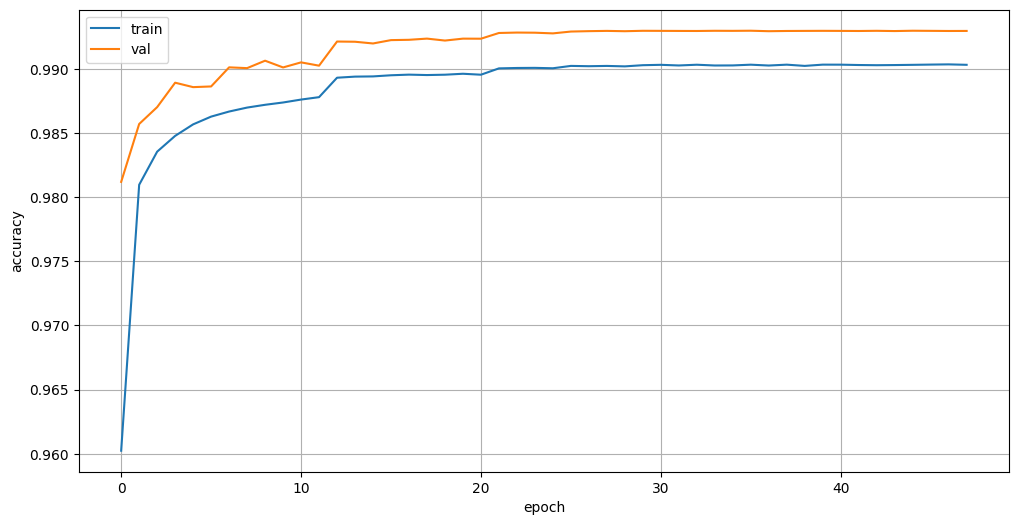

In [19]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.grid()

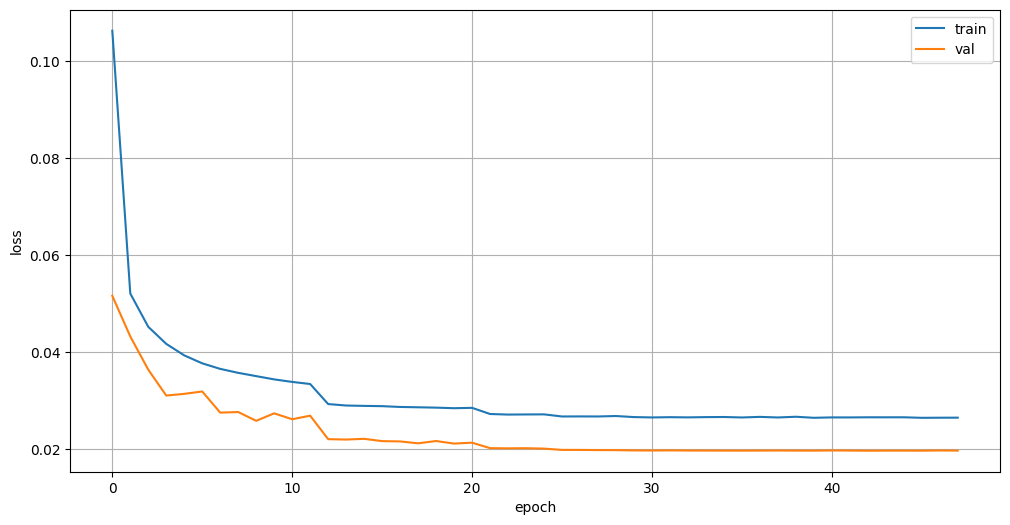

In [20]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.grid()

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 36)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         1,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,637 (25.93 KB)

 Trainable params: 2,161 (8.44 KB)

 Non-trainable params: 152 (608.00 B)

 Optimizer params: 4,324 (16.89 KB)

In [22]:
def check_and_create_directory(directory_path):
    """
    Checks if a directory exists, and if it does not, creates it.

    This function first checks whether the given directory path exists.
    If the directory does not exist, it attempts to create it using `os.makedirs()`.
    If the directory exists, it simply prints a message indicating so.
    If there is an error during directory creation, the exception is caught and an error message is displayed.

    Args:
        directory_path (str): The path of the directory to check and create if not present.

    Returns:
        None
    """

    # Check if the directory already exists
    if not os.path.exists(directory_path):

        try:
            # Create the directory if it does not exist
            os.makedirs(directory_path)
            print(f"Directory '{directory_path}' created.")

        except OSError as error:
            print(f"Error creating directory: {error}")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [23]:
# Create a directory to store the Keras model
check_and_create_directory('models')

# Build the Keras filename
prefix = datetime.now().strftime("%Y-%m-%d-%H-%M-%S-%f")[:-4]
filename = 'terrain-classification-model.keras'
path_and_filename = "".join(['models/', prefix, '-', filename])

# Save the model
model.save(path_and_filename)

Directory 'models' already exists.


In [24]:
new_model = tf.keras.models.load_model(path_and_filename, custom_objects=None, compile=True, safe_mode=True)
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 36)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         1,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,637 (25.93 KB)

 Trainable params: 2,161 (8.44 KB)

 Non-trainable params: 152 (608.00 B)

 Optimizer params: 4,324 (16.89 KB)

In [25]:
# Evaluate the model on the test data
loss, accuracy = new_model.evaluate(X_test, y_test) # Se evalua el modelo con los datos de prueba.
print(f"Test Accuracy: {accuracy:.4f}")

49285/49285 ━━━━━━━━━━━━━━━━━━━━ 44s 878us/step - accuracy: 0.9930 - loss: 0.0197
Test Accuracy: 0.9930


49285/49285 ━━━━━━━━━━━━━━━━━━━━ 28s 570us/step


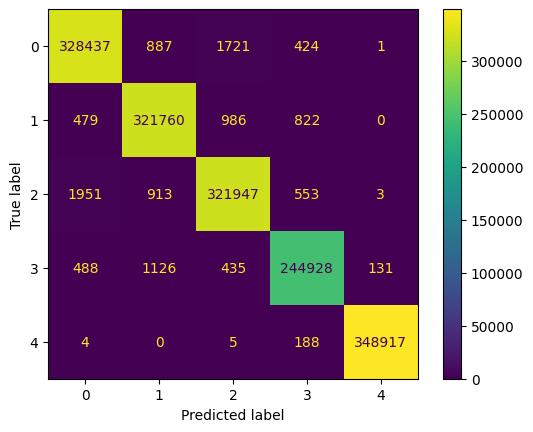

In [26]:
# Realizar las predicciones
y_probabilities = new_model.predict(X_test)

# Convertir las probabilidades en predicciones de clases (índices de la clase con la mayor probabilidad)
y_predictions = np.argmax(y_probabilities, axis=1)

# Calcular la matriz de confusión
c_matrix = confusion_matrix(y_true=y_test, y_pred=y_predictions)

# Mostrar la matriz de confusión
display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
display_matrix.plot()

In [27]:
print(f"\nClasification Report: \n\n{classification_report(y_test, y_predictions)}")


Clasification Report: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    331470
           1       0.99      0.99      0.99    324047
           2       0.99      0.99      0.99    325367
           3       0.99      0.99      0.99    247108
           4       1.00      1.00      1.00    349114

    accuracy                           0.99   1577106
   macro avg       0.99      0.99      0.99   1577106
weighted avg       0.99      0.99      0.99   1577106



In [28]:
accuracy = accuracy_score(y_test, y_predictions)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_test, y_predictions, average='macro')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test, y_predictions, average='macro')
print(f"Recall: {recall:0.4f}")

f1 = f1_score(y_test, y_predictions, average='macro')
print(f"F1-score: {f1:0.4f}")

Accuracy: 0.9930
Precision: 0.9928
Recall: 0.9928
F1-score: 0.9928
